In [6]:
import matplotlib.pyplot as plt
from numpy.random import default_rng
import numpy as np
import torch
import sys
import importlib

sys.path.append("../hw10")

from utils import split_data_gnn, train, MLP, get_batch_dimensions, visualize_graph
import torch.nn.functional as F
from torch import nn
from torch.utils.data import  DataLoader
from IPython.display import clear_output
import numpy as np
import mdtraj as md
from schnet import RadiusInteractionGraph, SchNet

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

### Generate some fake data

In [9]:
d = 1.1

# 3d cluster
clus3d = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)


In [10]:
n_particles = clus3d.shape[0]

In [11]:
n_samples = 10

positions = clus3d + torch.rand(size=(n_samples, n_particles,3))
potential_energies = torch.rand(size=(n_samples,1))
n_samples = potential_energies.shape[0]
positions.shape, potential_energies.shape

(torch.Size([10, 7, 3]), torch.Size([10, 1]))

We store the data in a Dataset. For now, we only need one dataset to make some tests. We assign atomic number of 1 to all particles

In [12]:
z = torch.ones((n_particles* n_samples,1))

We first make a histogram of all pairwise distances to get a feeling how our data is distributed. To do that, we use torch.vmap: It applies the mapped function over the first dimension.

In [13]:
# pairwise distances for all samples
distances = torch.vmap(F.pdist)(positions)
distances.shape

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/_functorch/vmap.py:391: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::pdist. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:85.)
  batched_outputs = func(*batched_inputs, **kwargs)


torch.Size([10, 21])

(array([ 5.,  5., 11., 16., 24.,  9., 11., 12., 18., 20., 21., 21., 12.,
         5.,  8.,  3.,  5.,  2.,  0.,  2.]),
 array([0.56946909, 0.6941905 , 0.81891185, 0.9436332 , 1.06835461,
        1.19307601, 1.31779742, 1.44251871, 1.56724012, 1.69196153,
        1.81668282, 1.94140422, 2.06612563, 2.19084692, 2.31556845,
        2.44028974, 2.56501102, 2.68973255, 2.81445384, 2.93917537,
        3.06389666]),
 <BarContainer object of 20 artists>)

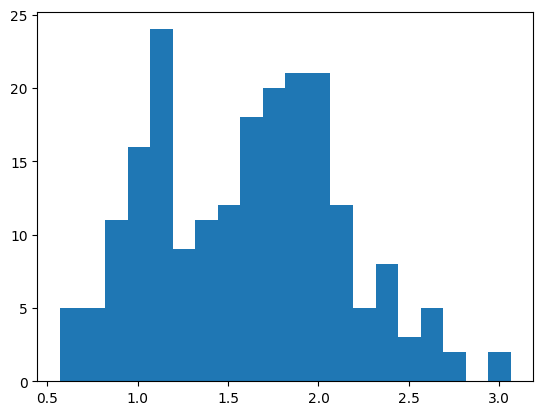

In [14]:
plt.hist(distances.flatten(),bins=20)

### Visualizing the interaction graph
We can now plot the interaction graph, which is the central object of a GNN. To do so, we use functions from pytorch_geometric. 

<span style="color:red">Caution:</span>

pytorch_geometric expects the input positions to be of shape (n_samples * n_particles, 3), rather than (n_samples, n_particles, 3). In practice, we can easily achieve that using reshape(-1,3), but it is important to keep that in mind.\

The batch_dimensions tell the code, which atom belongs to which sample of the array with shape (n_samples * n_particles, 3). For example: If we work with the first 14 entries, i.e., 2 samples from the MD run, the first seven positions correspond to one samples, and the second one to a different sample.

In [15]:
batch_dimensions = get_batch_dimensions(batch_size=3, n_particles=7)
batch_dimensions

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])

In [16]:
# select one frame from the MD simulation
id_plot = 5

# define a cutoff for the interaction
r_cut = 1.5

In [17]:
interaction_graph = RadiusInteractionGraph(r_cut)
batch_dimensions = get_batch_dimensions(batch_size=1, n_particles=7)

edges, distances = interaction_graph(
    positions[id_plot].reshape(-1, 3), batch_dimensions
)

edges.shape, distances.shape

ImportError: 'radius_graph' requires 'torch-cluster'

In [18]:
print(torch.__version__)

2.2.2


In [ ]:
visualize_graph(positions[id_plot].reshape(-1,3),edges,dim_1=0, dim_2=1)

### SchNet

In [ ]:
# initialize a SchNet model with default values
model = SchNet()

In [ ]:
# Let's get some information about the model parameters
print(model)

 You can check your implementation by passing the data to the model. This should look like the following:

In [ ]:
batch_dimensions = get_batch_dimensions(batch_size=10, n_particles=n_particles)

In [ ]:
# A forward pass of the model looks like this:
# out = model.forward(z,pos.reshape(-1,3),batch_dimensions)